# AI520: Natural Processing Language for Artificial Intelligence
Term: Summer 2025 \
Author: David Hiltzman \
Assignment: Team Project \
Team 01 \
Authors: \
Mitch Fade, David Hiltzman, Tyler Kepler, Jeff Nelson


## Abstract
This project will create a false news story detector using a publicly available Kaggle labeled dataset with known real and false stories. Data will first be preprocessed, and feature extraction will be performed. Classical machine learning (ML) methods and deep learning methods will be used to create classifiers of the preprocessed dataset and evaluated for effectiveness. Additionally, the explainability of the results will be analyzed to show which words contributed the most to the predictions. A false news detector may help bring clarity in a world of ever-growing misinformation and may give interesting results on which words are most common in fake news stories. 

## Startup

### Imports

In [41]:
# Import required libraries
import kagglehub
import os
import pandas as pd
import re
import shutil
import nltk
from pathlib import Path
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GroupKFold, cross_val_score
)
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    matthews_corrcoef, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/david/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Configuration Parameters

In [42]:
DATA_DIR = Path("./data")
RANDOM_STATE = 42
TEST_SIZE = 0.20

# Base "tells" to remove up-front (mostly publisher/style/boilerplate)
BASE_TELLS = {
    "reuters","washington","monday","tuesday","wednesday","thursday","friday","saturday","sunday",
    "nov","oct","sep","edt","london","york","mr","rep","sen",
    "video","image","read","watch","featured","getty","breaking","http","https","com","pic"
}

# How many top tokens (per class) to auto-ban after baseline model fit
TOP_K_TELLS_PER_CLASS = 50

# TF-IDF settings (word analyzer)
WORD_MAX_FEATURES = 5000
WORD_MIN_DF = 5
WORD_MAX_DF = 0.8
WORD_TOKEN_PATTERN = r"(?u)\b[a-zA-Z][a-zA-Z\-']+\b"

print("Configuration parameters set")


Configuration parameters set


## Preprocessing

### Text Preprocessing Functions

In [43]:
def preprocess_text(text):
    """
    Preprocess a given text string by normalizing, tokenizing, 
    removing stop words, and lemmatizing.
    
    Args:
        text: Input text string
        
    Returns:
        Preprocessed text string
    """
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(t) for t in tokens]   # Lemmatize
    return ' '.join(tokens)

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize column names by stripping whitespace and converting to lowercase."""
    df.columns = df.columns.str.strip().str.lower()
    return df

def ensure_date_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find a likely date column, parse to datetime, and write back to a unified 'date' column.
    If no date-like column exists, create an empty 'date' column.
    """
    candidates = [
        "date", "published", "publish_date", "publication_date",
        "pub_date", "created_at", "time", "timestamp"
    ]
    date_col = next((c for c in candidates if c in df.columns), None)
    
    if date_col is None:
        df["date"] = pd.NaT
    else:
        df["date"] = pd.to_datetime(df[date_col], errors="coerce")
    
    # Write dates as ISO strings (YYYY-MM-DD); keep NaN if unknown
    df["date"] = df["date"].dt.strftime("%Y-%m-%d")
    return df

def build_combined(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a 'combined' text field from 'processed_title' and 'processed_text'.
    Safely handles missing values, converts to strings, strips whitespace, and
    joins with a single space.
    """
    df["processed_title"] = df["processed_title"].fillna("").astype(str).str.strip()
    df["processed_text"]  = df["processed_text"].fillna("").astype(str).str.strip()
    df["combined"] = (df["processed_title"] + " " + df["processed_text"]).str.strip()
    return df

In [44]:
# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

print("Text preprocessing functions defined")

Text preprocessing functions defined


### Advanced Analysis Functions

In [45]:
def evaluate_and_report(name: str, model, X_test, y_test) -> None:
    """
    Print a suite of metrics on a held-out test set.
    """
    y_pred = model.predict(X_test)
    print(f"\n{name} — Held-out Test")
    print(classification_report(y_test, y_pred))
    
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
        print("ROC AUC:", round(roc_auc_score(y_test, probs), 4))
        print("AUCPR :", round(average_precision_score(y_test, probs), 4))
        print("MCC   :", round(matthews_corrcoef(y_test, y_pred), 4))
    else:
        print("MCC   :", round(matthews_corrcoef(y_test, y_pred), 4))

def leak_safe_cv_f1(
    X_text_train: List[str],
    y_train: np.ndarray,
    stop_words_list: List[str],
    n_splits: int = 5
) -> np.ndarray:
    """
    Compute leak-safe StratifiedKFold F1 scores on raw training text.
    Uses a scikit-learn Pipeline so TF-IDF is fit **inside each fold**, preventing
    vocabulary/IDF leakage from train to validation.
    """
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=WORD_MAX_FEATURES,
            token_pattern=WORD_TOKEN_PATTERN,
            min_df=WORD_MIN_DF,
            max_df=WORD_MAX_DF,
            stop_words=stop_words_list
        )),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)),
    ])
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, X_text_train, y_train, cv=skf, scoring="f1")
    return scores

def print_top_tokens(model: LogisticRegression, vectorizer: TfidfVectorizer, k: int = 25) -> None:
    """
    Print top positive/negative tokens by coefficient magnitude from a trained LogisticRegression.
    """
    coef = model.coef_[0]
    feats = vectorizer.get_feature_names_out()
    top_pos_idx = np.argsort(coef)[-k:][::-1]
    top_neg_idx = np.argsort(coef)[:k]
    print("Top TRUE tokens:", [feats[i] for i in top_pos_idx])
    print("Top FAKE tokens:", [feats[i] for i in top_neg_idx])

def analyze_errors(model, X_test_txt, X_test, y_test) -> pd.DataFrame:
    """
    Analyze model errors and return DataFrame with error analysis.
    """
    y_pred = model.predict(X_test)
    
    # Build a test frame to inspect mistakes
    test_df = pd.DataFrame({
        "text": X_test_txt,
        "y_true": y_test,
        "y_pred": y_pred,
        "p_true": model.predict_proba(X_test)[:, 1]
    })
    
    # Most confident wrong predictions
    wrong = test_df[test_df.y_true != test_df.y_pred].copy()
    wrong["margin"] = np.abs(wrong["p_true"] - 0.5)
    
    print("Wrong predictions:", len(wrong))
    print("\nTop 10 most confident errors:")
    top_errors = wrong.sort_values("margin", ascending=False).head(10)[["y_true","y_pred","p_true","text"]]
    for idx, row in top_errors.iterrows():
        print(f"True: {row['y_true']}, Pred: {row['y_pred']}, Prob: {row['p_true']:.3f}")
        print(f"Text: {row['text'][:200]}...")
        print("-" * 50)
    
    # Quick counts by error type
    print(f"\nFalse positives (pred 1, true 0): {(wrong.y_pred.eq(1) & wrong.y_true.eq(0)).sum()}")
    print(f"False negatives (pred 0, true 1): {(wrong.y_pred.eq(0) & wrong.y_true.eq(1)).sum()}")
    
    return test_df

print("Advanced analysis functions defined")

Advanced analysis functions defined


## Data Handling

### Download, verify, and save Kaggle Data

#### Download Kaggle Data

In [46]:
# Create data directory if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)
print(f"Created/verified data directory: {DATA_DIR}")

# Download dataset using kagglehub
try:    
    # Download latest version
    path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
    print("Path to dataset files:", path)
    
    # List files in the downloaded directory
    downloaded_files = os.listdir(path)
    print("Downloaded files:", downloaded_files)
    
    # Look for True.csv and Fake.csv (or similar names)
    true_file_candidates = [f for f in downloaded_files if 'true' in f.lower() and f.endswith('.csv')]
    fake_file_candidates = [f for f in downloaded_files if 'fake' in f.lower() and f.endswith('.csv')]
    
    print(f"True file candidates: {true_file_candidates}")
    print(f"Fake file candidates: {fake_file_candidates}")
    
    # Copy files to our data directory
    if true_file_candidates and fake_file_candidates:
        true_source = os.path.join(path, true_file_candidates[0])
        fake_source = os.path.join(path, fake_file_candidates[0])
        
        true_dest = os.path.join(DATA_DIR, "True.csv")
        fake_dest = os.path.join(DATA_DIR, "Fake.csv")
        
        shutil.copy2(true_source, true_dest)
        shutil.copy2(fake_source, fake_dest)
        
        print(f"Copied {true_file_candidates[0]} to {true_dest}")
        print(f"Copied {fake_file_candidates[0]} to {fake_dest}")
        
        # Set file paths for later use
        true_file_path = true_dest
        fake_file_path = fake_dest
        dataset_ready = True
        
    else:
        print("Could not find True.csv and Fake.csv files")
        print("Available files:", downloaded_files)
        dataset_ready = False
        
except ImportError:
    print("kagglehub not installed. Please install it with:")
    print("pip install kagglehub")
    dataset_ready = False
    
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("\nAlternative: Download manually from:")
    print("https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset")
    print("Then place True.csv and Fake.csv in the ./data directory")
    dataset_ready = False

Created/verified data directory: data
Path to dataset files: /home/david/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1
Downloaded files: ['Fake.csv', 'True.csv']
True file candidates: ['True.csv']
Fake file candidates: ['Fake.csv']
Copied True.csv to data/True.csv
Copied Fake.csv to data/Fake.csv


#### Verify Dataset Files

In [47]:
# Check if files exist in data directory
true_file_path = os.path.join(DATA_DIR, "True.csv")
fake_file_path = os.path.join(DATA_DIR, "Fake.csv")

if os.path.exists(true_file_path) and os.path.exists(fake_file_path):
    dataset_ready = True
    print(f"Dataset files ready:")
    print(f"  - {true_file_path}")
    print(f"  - {fake_file_path}")
else:
    print(f"Dataset files not found in {DATA_DIR}")
    dataset_ready = False

Dataset files ready:
  - data/True.csv
  - data/Fake.csv


#### Load and Explore Data

In [48]:
if dataset_ready:
    # Load the datasets
    print("Loading datasets...")
    df_true = pd.read_csv(true_file_path)
    df_fake = pd.read_csv(fake_file_path)
    
    # Normalize headers to avoid case/space issues
    df_true = normalize_columns(df_true)
    df_fake = normalize_columns(df_fake)
    
    # Make sure we have a usable 'date' column in both
    df_true = ensure_date_column(df_true)
    df_fake = ensure_date_column(df_fake)
    
    print("Datasets loaded successfully!")
    print(f"True dataset shape: {df_true.shape}")
    print(f"Fake dataset shape: {df_fake.shape}")
    print(f"\nTrue dataset columns: {df_true.columns.tolist()}")
    print(f"Fake dataset columns: {df_fake.columns.tolist()}")
    
    # Display first few rows to understand the data structure
    print("SAMPLE DATA - True News:")
    
    print(df_true.head(2))
    
    print("SAMPLE DATA - Fake News:")
    print(df_fake.head(2))
    
else:
    print("Cannot proceed - dataset not ready. Please run the previous cell successfully.")


Loading datasets...
Datasets loaded successfully!
True dataset shape: (21417, 4)
Fake dataset shape: (23481, 4)

True dataset columns: ['title', 'text', 'subject', 'date']
Fake dataset columns: ['title', 'text', 'subject', 'date']
SAMPLE DATA - True News:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject        date  
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews  2017-12-31  
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews  2017-12-29  
SAMPLE DATA - Fake News:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject        date  
0  Donald Trump just couldn t wish all Americans ...    News  2

###  Data Validation

#### Data Validation and Preprocessing

In [49]:
if dataset_ready:
    # Guard for missing title/text columns
    required = {"title", "text"}
    missing_true = required - set(df_true.columns)
    missing_fake = required - set(df_fake.columns)
    if missing_true:
        raise KeyError(f"True.csv missing required columns: {missing_true}")
    if missing_fake:
        raise KeyError(f"Fake.csv missing required columns: {missing_fake}")
    
    # Apply preprocessing to title and text columns
    print("Preprocessing text data...")
    df_true["processed_title"] = df_true["title"].astype(str).apply(preprocess_text)
    df_fake["processed_title"] = df_fake["title"].astype(str).apply(preprocess_text)
    df_true["processed_text"] = df_true["text"].astype(str).apply(preprocess_text)
    df_fake["processed_text"] = df_fake["text"].astype(str).apply(preprocess_text)
    print("Preprocessing complete!")
else:
    print("Cannot proceed - dataset not ready.")

Preprocessing text data...
Preprocessing complete!


#### Save Preprocessed Data

In [50]:
if dataset_ready:
    # Save preprocessed data
    df_true[["processed_title", "processed_text", "date"]].to_csv("preprocessed_True.csv", index=False)
    df_fake[["processed_title", "processed_text", "date"]].to_csv("preprocessed_Fake.csv", index=False)
    
    print("Preprocessed data saved to CSV files")
    print("Processed True dataset sample:")
    print(df_true[["processed_title", "processed_text", "date"]].head())
    print("\nProcessed Fake dataset sample:")
    print(df_fake[["processed_title", "processed_text", "date"]].head())
else:
    print("Cannot save - dataset not ready.")

Preprocessed data saved to CSV files
Processed True dataset sample:
                                     processed_title  \
0  u budget fight loom republican flip fiscal script   
1  u military accept transgender recruit monday p...   
2     senior u republican senator let mr mueller job   
3  fbi russia probe helped australian diplomat ti...   
4  trump want postal service charge much amazon s...   

                                      processed_text        date  
0  washington reuters head conservative republica...  2017-12-31  
1  washington reuters transgender people allowed ...  2017-12-29  
2  washington reuters special counsel investigati...  2017-12-31  
3  washington reuters trump campaign adviser geor...  2017-12-30  
4  seattle washington reuters president donald tr...  2017-12-29  

Processed Fake dataset sample:
                                     processed_title  \
0  donald trump sends embarrassing new year eve m...   
1  drunk bragging trump staffer started russian c

### Enhanced Data Preparation

In [51]:
if dataset_ready:
    # Load preprocessed data
    df_fake_processed = pd.read_csv("preprocessed_Fake.csv")
    df_true_processed = pd.read_csv("preprocessed_True.csv")
    
    # Ensure labels (0=fake, 1=true)
    if "label" not in df_fake_processed.columns: 
        df_fake_processed["label"] = 0
    if "label" not in df_true_processed.columns: 
        df_true_processed["label"] = 1
    
    # Build combined text
    df_fake_processed = build_combined(df_fake_processed)
    df_true_processed = build_combined(df_true_processed)
    
    # Merge, drop empties and exact duplicates
    df_combined = pd.concat([df_fake_processed, df_true_processed], ignore_index=True)
    df_combined = df_combined[df_combined["combined"] != ""].reset_index(drop=True)
    orig_n = len(df_combined)
    df_combined = df_combined.drop_duplicates(subset=["combined"]).reset_index(drop=True)
    
    print(f"Loaded shapes — fake: {df_fake_processed.shape}  true: {df_true_processed.shape}  merged: {df_combined.shape}")
    print(f"Dropped exact duplicate rows: {orig_n - len(df_combined)} (remaining: {len(df_combined)})")
    
    # Features/labels
    X_text = df_combined["combined"].astype(str).tolist()
    y = pd.to_numeric(df_combined["label"], errors="raise").to_numpy(dtype=np.int8)
    
    print(f"Combined dataset shape: {df_combined.shape}")
    print(f"Label distribution:\n{pd.Series(y).value_counts()}")
else:
    print("Cannot proceed - dataset not ready.")


Loaded shapes — fake: (23481, 5)  true: (21417, 5)  merged: (38833, 5)
Dropped exact duplicate rows: 6065 (remaining: 38833)
Combined dataset shape: (38833, 5)
Label distribution:
1    20928
0    17905
Name: count, dtype: int64


### Train-Test Split

In [52]:
if dataset_ready:
    # Stratified random split (no time-based aspect)
    X_train_txt, X_test_txt, y_train, y_test = train_test_split(
        X_text, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print("Train size:", len(y_train), " Test size:", len(y_test))
    print("Data split completed")
else:
    print("Cannot proceed - dataset not ready.")


Train size: 31066  Test size: 7767
Data split completed


## Modeling

### Enhanced Baseline Model with Leak-Safe CV

In [53]:
if dataset_ready:
    print("ENHANCED BASELINE MODEL WITH LEAK-SAFE CV")
    
    # CV on TRAIN with base tells removed
    custom_stop = set(ENGLISH_STOP_WORDS) | BASE_TELLS
    stop_words_list = sorted(custom_stop)
    cv_scores = leak_safe_cv_f1(X_train_txt, y_train, stop_words_list, n_splits=5)
    print("Leak-safe StratifiedKFold F1 (train):", cv_scores.mean())
    print("Per-fold F1:", cv_scores)
    
    # Fit baseline model and evaluate on TEST
    vec_word = TfidfVectorizer(
        max_features=WORD_MAX_FEATURES,
        token_pattern=WORD_TOKEN_PATTERN,
        min_df=WORD_MIN_DF,
        max_df=WORD_MAX_DF,
        stop_words=stop_words_list
    )
    X_train = vec_word.fit_transform(X_train_txt)
    X_test = vec_word.transform(X_test_txt)
    
    model_base = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
    model_base.fit(X_train, y_train)
    
    evaluate_and_report("Enhanced Baseline (word TF-IDF + base tells removed)", model_base, X_test, y_test)
    print_top_tokens(model_base, vec_word, k=25)
else:
    print("Cannot proceed - dataset not ready.")

ENHANCED BASELINE MODEL WITH LEAK-SAFE CV
Leak-safe StratifiedKFold F1 (train): 0.9719780324589495
Per-fold F1: [0.96990363 0.97679262 0.96999406 0.9699776  0.97322226]

Enhanced Baseline (word TF-IDF + base tells removed) — Held-out Test
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3581
           1       0.97      0.98      0.97      4186

    accuracy                           0.97      7767
   macro avg       0.97      0.97      0.97      7767
weighted avg       0.97      0.97      0.97      7767

ROC AUC: 0.9958
AUCPR : 0.996
MCC   : 0.9412
Top TRUE tokens: ['said', 'presidential', 'told', 'representative', 'spokesman', 'democratic', 'minister', 'rival', 'statement', 'ly', 'barack', 'comment', 'moscow', 'britain', 'senate', 'agency', 'house', 'republican', 'united', 'militant', 'citing', 'reporter', 'measure', 'myanmar', 'sap']
Top FAKE tokens: ['gop', 'hillary', 'like', 'america', 'know', 'american', 'isi', 'wire', 'obama

### Auto-Pruned Model

In [54]:
if dataset_ready:
    print("AUTO-PRUNED MODEL (REMOVING TOP CORRELATED TOKENS)")
    
    # Auto-prune top label-correlated tokens, retrain, re-evaluate
    coef = model_base.coef_[0]
    feats = vec_word.get_feature_names_out()
    top_pos = [w for _, w in sorted(zip(coef, feats), reverse=True)[:TOP_K_TELLS_PER_CLASS]]
    top_neg = [w for _, w in sorted(zip(coef, feats))[:TOP_K_TELLS_PER_CLASS]]
    auto_ban = set(top_pos + top_neg)
    
    print(f"Auto-banned {len(auto_ban)} highly correlated tokens")
    
    stop_words_list_pruned = sorted(set(stop_words_list) | auto_ban)
    cv_scores_pruned = leak_safe_cv_f1(X_train_txt, y_train, stop_words_list_pruned, n_splits=5)
    print("Leak-safe StratifiedKFold F1 (train) — PRUNED:", cv_scores_pruned.mean())
    print("Per-fold F1 (pruned):", cv_scores_pruned)
    
    vec_word_pruned = TfidfVectorizer(
        max_features=WORD_MAX_FEATURES,
        token_pattern=WORD_TOKEN_PATTERN,
        min_df=WORD_MIN_DF,
        max_df=WORD_MAX_DF,
        stop_words=stop_words_list_pruned
    )
    X_train_p = vec_word_pruned.fit_transform(X_train_txt)
    X_test_p = vec_word_pruned.transform(X_test_txt)
    
    model_pruned = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
    model_pruned.fit(X_train_p, y_train)
    
    evaluate_and_report("PRUNED (auto-ban top tokens per class)", model_pruned, X_test_p, y_test)
    print_top_tokens(model_pruned, vec_word_pruned, k=25)
else:
    print("Cannot proceed - dataset not ready.")

AUTO-PRUNED MODEL (REMOVING TOP CORRELATED TOKENS)
Auto-banned 100 highly correlated tokens
Leak-safe StratifiedKFold F1 (train) — PRUNED: 0.9493442654097362
Per-fold F1 (pruned): [0.94588165 0.95320676 0.94896593 0.94860718 0.95005981]

PRUNED (auto-ban top tokens per class) — Held-out Test
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3581
           1       0.95      0.96      0.95      4186

    accuracy                           0.95      7767
   macro avg       0.95      0.95      0.95      7767
weighted avg       0.95      0.95      0.95      7767

ROC AUC: 0.989
AUCPR : 0.9899
MCC   : 0.9013
Top TRUE tokens: ['adding', 'prime', 'criticism', 'senator', 'allegation', 'legislation', 'businessman', 'week', 'respond', 'earlier', 'criticized', 'rohingya', 'committee', 'sept', 'added', 'ahead', 'prosecutor', 'ipsos', 'contest', 'expected', 'official', 'denied', 'independently', 'seek', 'month']
Top FAKE tokens: ['pretty', 'lie'

### Character N-gram Model

In [55]:
if dataset_ready:
    print("CHARACTER N-GRAM MODEL")
    
    # Vectorize with character n-grams
    vectorizer_char = TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 4),
        min_df=5,
        max_df=0.9,
        max_features=30000,
        lowercase=True
    )
    X_train_char = vectorizer_char.fit_transform(X_train_txt)
    X_test_char = vectorizer_char.transform(X_test_txt)
    print("Char TF-IDF shapes:", X_train_char.shape, X_test_char.shape)
    
    # Train & evaluate character n-gram model
    model_char = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
    model_char.fit(X_train_char, y_train)
    
    evaluate_and_report("Character N-grams (3-4)", model_char, X_test_char, y_test)
    
    # Top positive/negative character n-grams
    coef_char = model_char.coef_[0]
    feats_char = vectorizer_char.get_feature_names_out()
    top_pos_char = np.argsort(coef_char)[-25:][::-1]
    top_neg_char = np.argsort(coef_char)[:25]
    print("Top TRUE (class 1) char n-grams:", [feats_char[i] for i in top_pos_char])
    print("Top FAKE (class 0) char n-grams:", [feats_char[i] for i in top_neg_char])
else:
    print("Cannot proceed - dataset not ready.")

CHARACTER N-GRAM MODEL
Char TF-IDF shapes: (31066, 30000) (7767, 30000)

Character N-grams (3-4) — Held-out Test
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3581
           1       0.98      0.99      0.99      4186

    accuracy                           0.99      7767
   macro avg       0.99      0.99      0.99      7767
weighted avg       0.99      0.99      0.99      7767

ROC AUC: 0.9986
AUCPR : 0.9985
MCC   : 0.9723
Top TRUE (class 1) char n-grams: ['eut', 'reut', ' reu', 'eute', 'reu', 'uter', 'ters', 'ers ', 'ute', ' sai', 'said', 'sai', 'aid', 'rs ', 'aid ', 'id ', 'ers', ' u ', 'day', 'day ', 'sday', 'sda', 'rs u', 'on r', 'u pr']
Top FAKE (class 0) char n-grams: [' via', 'via ', 'via', ' vi', 'deo', 'ideo', ' vid', ' ima', 'imag', 'deo ', 'ly ', 'ima', 'vide', 'mage', 'eo ', 'mag', 'vid', 'gop', ' rea', 'gop ', ' gop', 'mr ', ' mr', 'rea', 'eve']


### Traditional Classifiers with Enhanced Features

In [56]:
if dataset_ready:
    print("TRADITIONAL CLASSIFIERS WITH ENHANCED FEATURES")
    
    # Random Forest
    print("\nRANDOM FOREST CLASSIFIER")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    evaluate_and_report("Random Forest (Enhanced Features)", rf_model, X_test, y_test)
    
    # Linear SVM
    print("\nLINEAR SVM CLASSIFIER")
    svm_model = make_pipeline(
        StandardScaler(with_mean=False),
        LinearSVC(dual="auto", C=1.0, tol=1e-3, max_iter=5000, random_state=RANDOM_STATE)
    )
    svm_model.fit(X_train, y_train)
    evaluate_and_report("Linear SVM (Enhanced Features)", svm_model, X_test, y_test)
else:
    print("Cannot proceed - dataset not ready.")

TRADITIONAL CLASSIFIERS WITH ENHANCED FEATURES

RANDOM FOREST CLASSIFIER

Random Forest (Enhanced Features) — Held-out Test
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3581
           1       0.96      0.97      0.96      4186

    accuracy                           0.96      7767
   macro avg       0.96      0.96      0.96      7767
weighted avg       0.96      0.96      0.96      7767

ROC AUC: 0.9933
AUCPR : 0.9937
MCC   : 0.9228

LINEAR SVM CLASSIFIER

Linear SVM (Enhanced Features) — Held-out Test
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3581
           1       0.95      0.96      0.96      4186

    accuracy                           0.96      7767
   macro avg       0.96      0.96      0.96      7767
weighted avg       0.96      0.96      0.96      7767

MCC   : 0.9109


## Evaluation

### Confusion Matrices Visualization

CONFUSION MATRICES VISUALIZATION


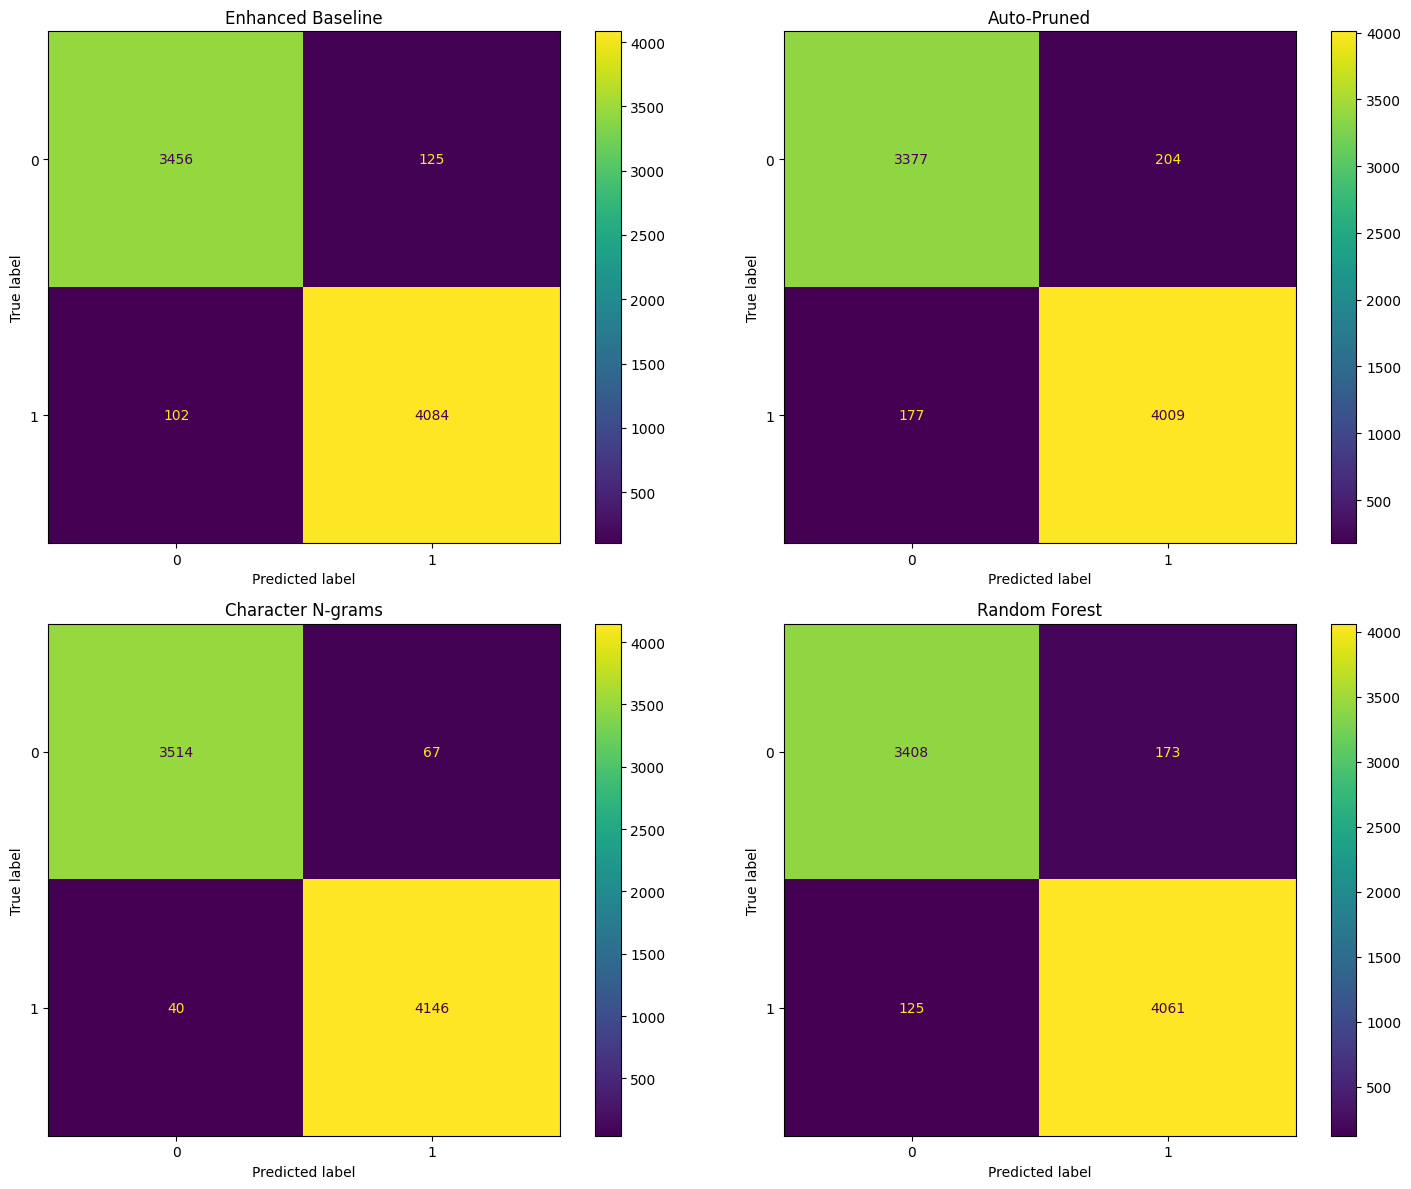

In [ ]:
if dataset_ready:
    print("CONFUSION MATRICES VISUALIZATION")
    
    # Individual confusion matrices
    disp_base = ConfusionMatrixDisplay.from_estimator(model_base, X_test, y_test)
    disp_base.figure_.savefig("confusion_matrix_enhanced_baseline.png")
    plt.close(disp_base.figure_)
    
    disp_pruned = ConfusionMatrixDisplay.from_estimator(model_pruned, X_test_p, y_test)
    disp_pruned.figure_.savefig("confusion_matrix_auto_pruned.png")
    plt.close(disp_pruned.figure_)
    
    disp_char = ConfusionMatrixDisplay.from_estimator(model_char, X_test_char, y_test)
    disp_char.figure_.savefig("confusion_matrix_char_ngrams.png")
    plt.close(disp_char.figure_)
    
    disp_rf = ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
    disp_rf.figure_.savefig("confusion_matrix_random_forest.png")
    plt.close(disp_rf.figure_)
    
    # Combined 2x2 confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    ConfusionMatrixDisplay.from_estimator(model_base, X_test, y_test, ax=axes[0,0])
    axes[0,0].set_title("Enhanced Baseline")
    
    ConfusionMatrixDisplay.from_estimator(model_pruned, X_test_p, y_test, ax=axes[0,1])
    axes[0,1].set_title("Auto-Pruned")
    
    ConfusionMatrixDisplay.from_estimator(model_char, X_test_char, y_test, ax=axes[1,0])
    axes[1,0].set_title("Character N-grams")
    
    ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axes[1,1])
    axes[1,1].set_title("Random Forest")
    
    plt.tight_layout()
    fig.savefig("confusion_matrices_combined.png")
    plt.show()
else:
    print("Cannot proceed - dataset not ready.")


### Error Analysis

In [58]:
if dataset_ready:
    print("ERROR ANALYSIS - ENHANCED BASELINE MODEL")
    error_df = analyze_errors(model_base, X_test_txt, X_test, y_test)
else:
    print("Cannot proceed - dataset not ready.")

if dataset_ready:
    print("MODEL COMPARISON SUMMARY")
    print("All models trained on the same train/test split (random_state=42)")
    print("Dataset size:", df_combined.shape[0], "samples")
else:
    print("Cannot proceed - dataset not ready.")

ERROR ANALYSIS - ENHANCED BASELINE MODEL
Wrong predictions: 227

Top 10 most confident errors:
True: 0, Pred: 1, Prob: 0.992
Text: breaking iran throw ultimatum move barry nuclear industry necessity energy production desalination field medicine agriculture sector iran supreme leader ayatollah ali khameneiso many lie finally time ...
--------------------------------------------------
True: 1, Pred: 0, Prob: 0.018
Text: highlight reuters exclusive interview donald trump reuters highlight reuters oct 25 exclusive interview republican presidential nominee donald trump hillary clinton plan syria look end world war three...
--------------------------------------------------
True: 0, Pred: 1, Prob: 0.977
Text: n korea latest missile launch aimed testing carrying large scale heavy nuclear warhead north korea said monday successfully conducted newly developed mid long range missile test sunday supervised lead...
--------------------------------------------------
True: 0, Pred: 1, Prob: 0.975
Te